In [0]:
import os
import cv2
import torch
import shutil
import numpy as np
from time import time
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

In [0]:
def copy_data(data_path_drive, data_path, name):
    if os.path.exists(os.path.join(data_path, name)):
        print('Data already present. Not copying!')
    else:
        print('Copying data from drive....')
        start = time()
        src = os.path.join(data_path_drive, name)
        dst = os.path.join(data_path, name)
        shutil.copyfile(src, dst)
        end = time()
        print('Copied | Time Elapsed --> {} seconds'.format(end - start))

data_path = 'data'
data_path_drive = 'drive/My Drive/celeb_detection/data'

model_path = 'model'
model_path_drive = 'drive/My Drive/celeb_detection/model'

frame_path = 'frames'

if not os.path.exists(data_path):
        os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(frame_path):
    os.makedirs(frame_path)

test_file = 'test.jpg'
image_name = 'drive.jpg'
video_name = 'bvs.mp4'
model_name_resnet = 'srresnet_14.pt'
model_name_gan = 'srgan_gen.pt'
model_file_1 = 'srgan.py'
model_file_2 = 'srresnet.py'
copy_data(data_path_drive, '.', model_file_1)
copy_data(data_path_drive, '.', model_file_2)
copy_data(data_path_drive, data_path, test_file)
copy_data(data_path_drive, data_path, image_name)
copy_data(data_path_drive, data_path, video_name)
copy_data(model_path_drive, model_path, model_name_resnet)
copy_data(model_path_drive, model_path, model_name_gan)

Copying data from drive....
Copied | Time Elapsed --> 0.7247743606567383 seconds
Copying data from drive....
Copied | Time Elapsed --> 0.8130471706390381 seconds
Copying data from drive....
Copied | Time Elapsed --> 1.8079299926757812 seconds
Copying data from drive....
Copied | Time Elapsed --> 3.2891414165496826 seconds
Copying data from drive....
Copied | Time Elapsed --> 8.512996196746826 seconds


In [0]:
device = 'cuda'
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
model_resnet = torch.load('model/checkpoint_srresnet.pth.tar')['model'].to(device)
model_gan = torch.load('model/checkpoint_srgan.pth.tar')['generator'].to(device)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.SRResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.ConvolutionalBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.ResidualBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True`

In [0]:
def test_video():
    print('Testing on {}'.format(torch.cuda.get_device_name(0)))
    cap = cv2.VideoCapture('data/bvs.mp4')
    frames_path = 'frames'
    if not os.path.exists('frames'):
        os.makedirs('frames')
    c = 0
    start = time()
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            img = frame
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            if (img.width >= 1920 and img.width < 3840) or (img.height >= 1080 and img.height < 2160):
                img = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)
            elif img.width >= 3840 or img.height >= 2160:
                img = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
            output = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
            resized_output = output.resize((img.width, img.height), Image.BICUBIC)
            transform = ToTensor()
            lr_img = transform(output)
            if lr_img.ndimension() == 3:
                lr_img = (lr_img - imagenet_mean) / imagenet_std
            elif lr_img.ndimension() == 4:
                lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda
            with torch.no_grad():
                sr_resnet_output = model_resnet(lr_img.unsqueeze(0).to(device))
                sr_gan_output = model_gan(lr_img.unsqueeze(0).to(device))
            
            transform_1 = ToPILImage()
            
            sr_resnet_output = sr_resnet_output.squeeze(0).cpu().detach()
            sr_resnet_output = (sr_resnet_output + 1.) / 2.
            sr_resnet_output = transform_1(sr_resnet_output)

            sr_gan_output = sr_gan_output.squeeze(0).cpu().detach()
            sr_gan_output = (sr_gan_output + 1.) / 2.
            sr_gan_output = transform_1(sr_gan_output)

            frame_save_path = os.path.join(frames_path, str(c) + '.jpg')
            # sr_output.save(frame_save_path)
            grid_image = Image.new('RGB', (2 * img.width, img.height))
            x_offset = 0
            grid_image.paste(resized_output, (x_offset, 0))
            x_offset += img.width
            grid_image.paste(sr_gan_output, (x_offset, 0))
            grid_image.save(frame_save_path)
            c += 1
            print('Frame {} saved'.format(c))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    end = time()
    print('Processed Video | Time Elapsed --> {} seconds'.format(end - start))

In [0]:
def main():
    print('Testing on {}'.format(torch.cuda.get_device_name(0)))
    img = Image.open('data/witcher3.jpg', mode='r')
    # model.eval()
    img = img.convert('RGB')
    if (img.width >= 1920 and img.width < 3840) or (img.height >= 1080 and img.height < 2160):
        img = img.resize((img.width // 2, img.height // 2), Image.BICUBIC)
    elif img.width >= 3840 or img.height >= 2160:
        img = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    output = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    resized_output = output.resize((img.width, img.height), Image.BICUBIC)
    transform = ToTensor()
    lr_img = transform(output)
    if lr_img.ndimension() == 3:
        lr_img = (lr_img - imagenet_mean) / imagenet_std
    elif lr_img.ndimension() == 4:
        lr_img = (lr_img - imagenet_mean_cuda) / imagenet_std_cuda
    with torch.no_grad():
        sr_resnet_output = model_resnet(lr_img.unsqueeze(0).to(device))
        sr_gan_output = model_gan(lr_img.unsqueeze(0).to(device))
    
    transform_1 = ToPILImage()

    sr_resnet_output = sr_resnet_output.squeeze(0).cpu().detach()
    sr_resnet_output = (sr_resnet_output + 1.) / 2.
    sr_resnet_output = transform_1(sr_resnet_output)

    sr_gan_output = sr_gan_output.squeeze(0).cpu().detach()
    sr_gan_output = (sr_gan_output + 1.) / 2.
    sr_gan_output = transform_1(sr_gan_output)

    grid_image = Image.new('RGB', (2 * img.width, img.height))
    x_offset = 0
    grid_image.paste(resized_output, (x_offset, 0))
    x_offset += img.width
    # grid_image.paste(sr_resnet_output, (x_offset, 0))
    # x_offset += img.width
    grid_image.paste(sr_gan_output, (x_offset, 0))
    grid_image.save('output.jpg')
    return grid_image

Testing on Tesla P4


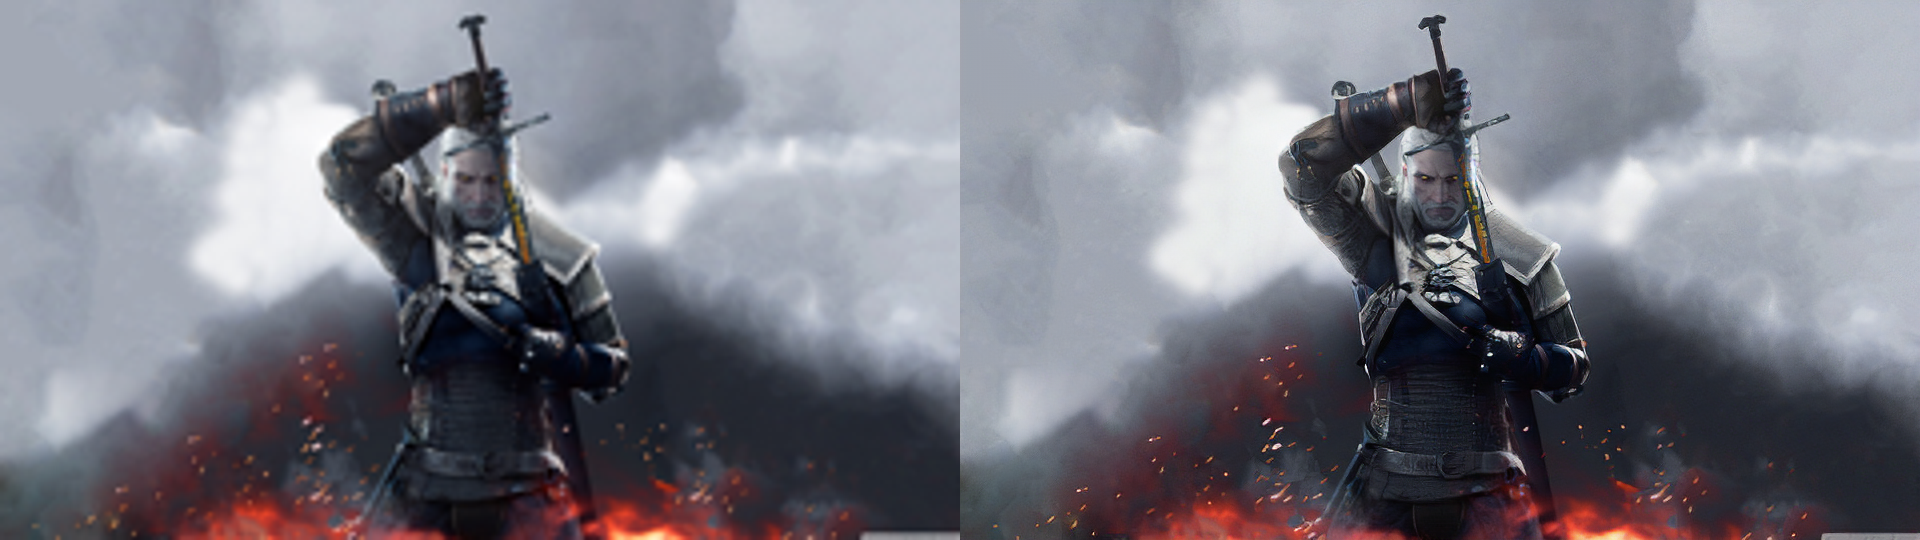

In [0]:
grid_image = main()
grid_image

In [0]:
test_video()

Testing on Tesla P4
Frame 1 saved
Frame 2 saved
Frame 3 saved
Frame 4 saved
Frame 5 saved
Frame 6 saved
Frame 7 saved
Frame 8 saved
Frame 9 saved
Frame 10 saved
Frame 11 saved
Frame 12 saved
Frame 13 saved
Frame 14 saved
Frame 15 saved
Frame 16 saved
Frame 17 saved
Frame 18 saved
Frame 19 saved
Frame 20 saved
Frame 21 saved
Frame 22 saved
Frame 23 saved
Frame 24 saved
Frame 25 saved
Frame 26 saved
Frame 27 saved
Frame 28 saved
Frame 29 saved
Frame 30 saved
Frame 31 saved
Frame 32 saved
Frame 33 saved
Frame 34 saved
Frame 35 saved
Frame 36 saved
Frame 37 saved
Frame 38 saved
Frame 39 saved
Frame 40 saved
Frame 41 saved
Frame 42 saved
Frame 43 saved
Frame 44 saved
Frame 45 saved
Frame 46 saved
Frame 47 saved
Frame 48 saved
Frame 49 saved
Frame 50 saved
Frame 51 saved
Frame 52 saved
Frame 53 saved
Frame 54 saved
Frame 55 saved
Frame 56 saved
Frame 57 saved
Frame 58 saved
Frame 59 saved
Frame 60 saved
Frame 61 saved
Frame 62 saved
Frame 63 saved
Frame 64 saved
Frame 65 saved
Frame 66 saved

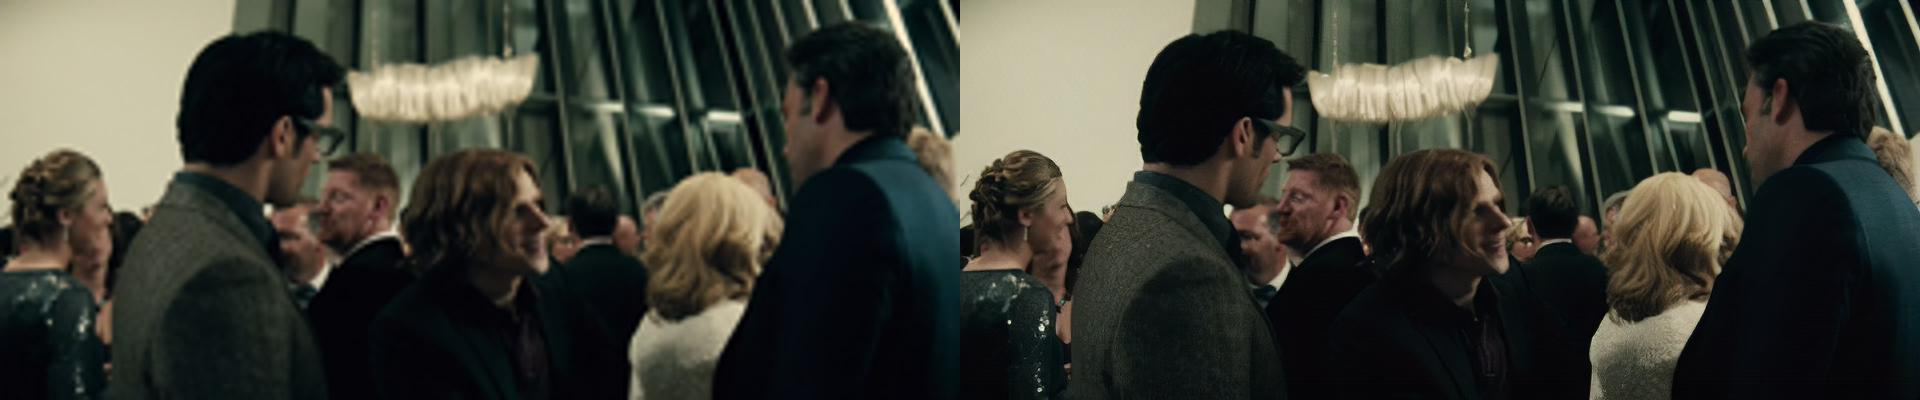

In [0]:
img = Image.open('frames/0.jpg')
img

In [0]:
# zip frames folder

shutil.make_archive('frames', 'zip', 'frames')

'/content/frames.zip'

In [0]:
# copy zip file back to drive

start = time()

src_file = 'frames.zip'
dst_file = 'drive/My Drive/celeb_detection/frames.zip'
shutil.copyfile(src_file, dst_file)

print('Copied Zip File to Drive | Time elapsed --> {} seconds'.format(strftime("%H:%M:%S", gmtime(time()-start))))

In [0]:
!rm -rf frames